In [1]:
import networkx as nx 
import numpy as np
import pandas as pd
import pickle
import random
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics

### bi-network cad

In [107]:
with open(r'D:\study\thesis\project\HBDM-main\data\disease\cad_node.pkl', 'rb') as file:
    group_node = pickle.load(file)

neighbor_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\cad_neighbors_temp_bi.csv')

network = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\ppi_connect.csv')

string_score_transform = lambda x: -np.log(x/1000)
network['continuous'] = network['combined_score'].apply(string_score_transform)
G = nx.from_pandas_edgelist(network, source='node1', target='node2', edge_attr='continuous', create_using=nx.Graph)

### g_network

In [109]:
neighbor_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\cad_neighbors_temp_gg.csv')

In [110]:
ks = [3,5,10,25,50,75,100]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kfresults = []
for train_index, test_index in kf.split(group_node):
    train_nodes = [group_node[i] for i in train_index]
    test_nodes = [group_node[i] for i in test_index]
    
    kfneighbor_df = neighbor_df[neighbor_df['start'].isin(train_nodes)]
    results = []
    groups = kfneighbor_df.groupby('start')
    for k in ks:
        
        for i, (key, subdf) in enumerate(groups):
            subdf = subdf.head(k)
            if i == 0:
                kneighbor_df = subdf
            else:
                kneighbor_df = pd.concat([kneighbor_df, subdf], ignore_index=True)
        kneighbor_df = kneighbor_df[~kneighbor_df['neighbor'].isin(train_nodes)]
        predict_df = kneighbor_df['neighbor'].value_counts().to_frame()
        predict_df.reset_index(inplace=True)
        predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
        predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in test_nodes else 0, axis=1)
        if len(predict_df[predict_df['true']==1])==0:
            results.append([0, 0])
        else:
            predicted_positives = predict_df['count']
            true_positives = predict_df['true']
            precision, recall, thresholds = metrics.precision_recall_curve(true_positives,predicted_positives)
            roc,pr= metrics.roc_auc_score(true_positives,predicted_positives),metrics.auc(recall,precision)
            results.append([roc,pr])
    kfresults.append(results)
kfresults = np.array(kfresults)
all_res = np.mean(kfresults, axis=0)
roc_ks = all_res[:, 0]
pr_ks = all_res[:, 1]
roc_ks,pr_ks

(array([0.61128607, 0.62444633, 0.63327426, 0.61529834, 0.60204676,
        0.59632893, 0.59240534]),
 array([0.1113451 , 0.10784364, 0.09063786, 0.0670033 , 0.05899256,
        0.05597236, 0.05405914]))

In [95]:
# sp cad bi
# (array([0.5587694 , 0.57828225, 0.59529003, 0.63259433, 0.66840065,
#         0.69077752, 0.6935744 ]),
#  array([0.06399026, 0.06378134, 0.06264023, 0.05992439, 0.05625323,
#         0.05337278, 0.05063705]))
# sp cad 10
# [array([0.61457747, 0.62742304, 0.65243125, 0.65516545, 0.6492224 ,
#        0.64148328, 0.63666845]), 
#        array([0.12010561, 0.10943346, 0.09786825, 0.08180575, 0.07165748,
#        0.06702653, 0.06514911])]
# sp cad gg
# (array([0.61128607, 0.62444633, 0.63327426, 0.61529834, 0.60204676,
#         0.59632893, 0.59240534]),
#  array([0.1113451 , 0.10784364, 0.09063786, 0.0670033 , 0.05899256,
#         0.05597236, 0.05405914]))

0.558769396

In [7]:
for k in ks:
    kneighbor_df = pd.DataFrame()
    for key, subdf in groups:
        subdf = subdf.head(k)
        kneighbor_df = pd.concat([kneighbor_df, subdf], ignore_index=True)
    kneighbor_df = kneighbor_df[~kneighbor_df['neighbor'].isin(train_nodes)]
    predict_df = kneighbor_df['neighbor'].value_counts().to_frame()
    predict_df.reset_index(inplace=True)
    predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
    predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in test_nodes else 0, axis=1)
if len(predict_df[predict_df['true']==1])==0:
    results.append([0, 0])
else:
    predicted_positives = predict_df['count']
    true_positives = predict_df['true']
    precision, recall, thresholds = metrics.precision_recall_curve(true_positives,predicted_positives)
    roc,pr= metrics.roc_auc_score(true_positives,predicted_positives),metrics.auc(recall,precision)

### link prediction

In [2]:
root = 'D:/study/thesis/project/HBDM-main/data/datasets/ppi/'
 
 
sparse_i = np.loadtxt(root+'sparse_i.txt')
sparse_j = np.loadtxt(root+'sparse_j.txt')
sparse_w = np.loadtxt(root+'sparse_w.txt')
 
sparse_i = sparse_i.astype(int)
sparse_j = sparse_j.astype(int)
sparse_w = sparse_w.astype(float)
 
# string_score_transform = np.vectorize(lambda x: -np.log(x/1000))
# transformed_w = string_score_transform(sparse_w)
# transformed_w = 11-(sparse_w*10).round()
# edges_and_weights = zip(sparse_i, sparse_j,transformed_w)
 
# G = nx.Graph()
 
# # Use from_edgelist to directly create the graph from edges
# G.add_weighted_edges_from(edges_and_weights)
# len(G.nodes)

In [3]:
sparse_w

array([0.311, 0.161, 0.499, ..., 0.215, 0.19 , 0.8  ])

In [9]:
np.count_nonzero(transformed_w == 0)

0

In [74]:
sparse_i_rem = np.loadtxt(root+'sparse_i_rem.txt')
sparse_j_rem = np.loadtxt(root+'sparse_j_rem.txt')
sparse_i_rem = sparse_i_rem.astype(int)[:10]
sparse_j_rem = sparse_j_rem.astype(int)

non_sparse_i = np.loadtxt(root+'non_sparse_i.txt')
non_sparse_j = np.loadtxt(root+'non_sparse_j.txt')
non_sparse_i = non_sparse_i.astype(int)
non_sparse_j = non_sparse_j.astype(int)

test_i = np.concatenate((sparse_i_rem, non_sparse_i))
test_j = np.concatenate((sparse_j_rem, non_sparse_j))

In [75]:
true_label = np.array([1]*sparse_i_rem.shape[0]+[0]*non_sparse_i.shape[0])

In [81]:
predict_label = []
for i, source in enumerate(test_i):
    target = test_j[i]
    try:
        predict_label.append(1/nx.shortest_path_length(G, source=source, target=target,weight='weight'))
    except nx.NetworkXNoPath:
        predict_label.append(0)

precision, recall, thresholds = metrics.precision_recall_curve(true_label,predict_label)
roc,pr= metrics.roc_auc_score(true_label,predict_label),metrics.auc(recall,precision)

In [84]:
pr

0.9030569430569431

In [10]:
with open(r'D:\study\thesis\project\HBDM-main\ppi_results\sp_results\sp_lp\sp_lp_bi.pkl', 'rb') as file:
    splpbi = pickle.load(file)

In [11]:
true_labels = splpbi[0]
predicted_scores = splpbi[1]

In [12]:
metrics.roc_auc_score(true_labels,predicted_scores)

0.8238680631526121

In [14]:
precision, recall, thresholds = metrics.precision_recall_curve(true_labels,predicted_scores)
roc,pr= metrics.roc_auc_score(true_labels,predicted_scores),metrics.auc(recall,precision)

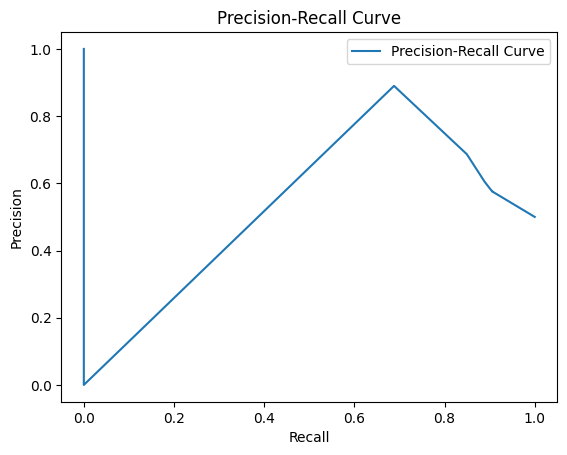

In [16]:
# Assuming you have calculated precision, recall, and thresholds using metrics.precision_recall_curve
precision, recall, thresholds = metrics.precision_recall_curve(true_labels, predicted_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

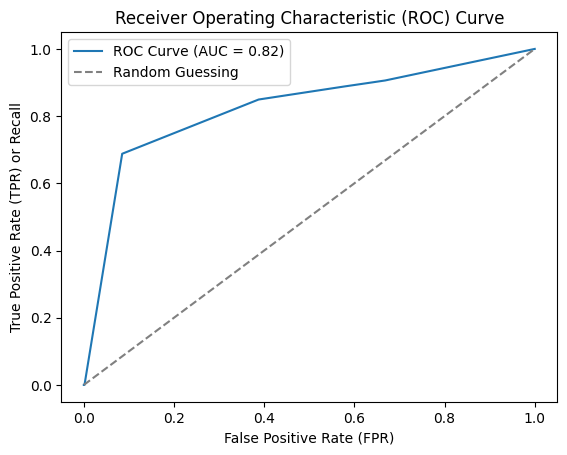

In [17]:
# Assuming you have calculated fpr (false positive rate), tpr (true positive rate), and thresholds using metrics.roc_curve
fpr, tpr, thresholds = metrics.roc_curve(true_labels, predicted_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()